In [1]:
import pandas as pd
import numpy as np
import copy
from datetime import datetime
import pickle 
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, roc_auc_score
import ubjson

from sklearn.datasets import load_breast_cancer
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import GridSearchCV
import gzip


import lightgbm as lgb

pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [2]:
fp_clients = '../data/clients_attributes.csv'
fp_sales = '../data/sales.csv'

fp_active_promos = '../data/active_promos.csv'
fp_executed_promos = '../data/executed_promos.csv'
fp_test = '../data/test.csv'

df_active_promos = pd.read_csv(fp_active_promos, encoding='ISO-8859-1', sep=',')
df_clients = pd.read_csv(fp_clients, encoding='ISO-8859-1', sep=',')
df_executed_promos = pd.read_csv(fp_executed_promos, encoding='ISO-8859-1', sep=',')
df_sales = pd.read_csv(fp_sales, encoding='ISO-8859-1', sep=',')
df_test = pd.read_csv(fp_test, encoding='ISO-8859-1', sep=',')

In [3]:
# Crear periodo, como el mes de la mediana entre fecha_desde y fecha_hasta
df_active_promos['fecha_desde_dt'] \
  = pd.to_datetime(df_active_promos['Fecha_Desde'], format = '%Y-%m-%d')
df_active_promos['fecha_hasta_dt'] \
  = pd.to_datetime(df_active_promos['Fecha_Hasta'], format = '%Y-%m-%d')

df_active_promos['mid_date'] \
  = df_active_promos['fecha_desde_dt'] + \
    (df_active_promos['fecha_hasta_dt'] - df_active_promos['fecha_desde_dt']) /2

df_active_promos['periodo'] = df_active_promos['mid_date'].apply(lambda dt: dt.replace(day = 1))

df_active_promos['month_year'] = df_active_promos['periodo'].dt.to_period('M')
# Dropear columnas innecesarias
df_active_promos = df_active_promos.drop(['Fecha_Desde', 'Fecha_Hasta', 'fecha_desde_dt',
                                          'fecha_hasta_dt', 'mid_date', 'periodo'], axis = 1)
df_active_promos.head(1)

,CodigoDC,Marca,Cupo,Cliente,month_year
0,297601,29,9,3213,2018-08


In [4]:
fechas_active_promos = list(df_active_promos['month_year'].unique())
fechas_active_promos

[Period('2018-08', 'M'),
 Period('2018-09', 'M'),
 Period('2018-10', 'M'),
 Period('2018-11', 'M'),
 Period('2018-12', 'M'),
 Period('2019-01', 'M'),
 Period('2019-02', 'M'),
 Period('2019-03', 'M'),
 Period('2019-04', 'M'),
 Period('2019-07', 'M'),
 Period('2019-05', 'M'),
 Period('2019-06', 'M'),
 Period('2019-08', 'M'),
 Period('2019-09', 'M')]

In [5]:
# Quitare manualmente los active_promos de septiembre 2019 debido a que no hay match con executed_promos
#df_active_promos = df_active_promos[df_active_promos['month_year']!=fechas_active_promos[-1]]
df_active_promos = df_active_promos[df_active_promos['month_year']!= '201909']

In [6]:
df_active_promos['month_year'].unique()

<PeriodArray>
['2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
 '2019-03', '2019-04', '2019-07', '2019-05', '2019-06', '2019-08']
Length: 13, dtype: period[M]

In [7]:
print(df_executed_promos.isna().sum())
# Agregar label a executed_promos
df_executed_promos['label'] = 1
display(df_executed_promos.head(1))

CodigoDC    0
Cliente     0
Marca       0
Cupo        0
dtype: int64


,CodigoDC,Cliente,Marca,Cupo,label
0,297601,8410,29,9,1


In [8]:
print(f"Numero de registros en active promos: {len(df_active_promos)}")
df_m1 = pd.merge(
  df_active_promos,
  df_executed_promos,
  on = ['CodigoDC', 'Cliente', 'Marca', 'Cupo'],
  how = 'left')
print(f"Numero de registros en df_m1: {len(df_m1)}")

Numero de registros en active promos: 385802
Numero de registros en df_m1: 385802


In [9]:
# Llenamos NaN con 0, 0 implica que el cliente no acepto la promocion
df_m1 = df_m1.fillna(0)

In [10]:
fechas_m1 = list(df_m1['month_year'].unique())
fechas_m1.sort()
fechas_m1

[Period('2018-08', 'M'),
 Period('2018-09', 'M'),
 Period('2018-10', 'M'),
 Period('2018-11', 'M'),
 Period('2018-12', 'M'),
 Period('2019-01', 'M'),
 Period('2019-02', 'M'),
 Period('2019-03', 'M'),
 Period('2019-04', 'M'),
 Period('2019-05', 'M'),
 Period('2019-06', 'M'),
 Period('2019-07', 'M'),
 Period('2019-08', 'M')]

In [11]:
# Agregamos informacion de clientes DIRECTA
df_clients.head(1)

,Cliente,FechaAltaCliente,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,1,2009-03-03,4,21,12,1,1,1


In [12]:
df_m2 = pd.merge(
  df_m1, 
  df_clients[['Cliente', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF']],
  on = 'Cliente',
  how = 'left'
)
print(df_m2.isna().sum())
display(df_m2.head(1))

CodigoDC         0
Marca            0
Cupo             0
Cliente          0
month_year       0
label            0
Region           0
Gerencia         0
SubCanal         0
TipoPoblacion    0
Estrato          0
EF               0
dtype: int64


,CodigoDC,Marca,Cupo,Cliente,month_year,label,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF
0,297601,29,9,3213,2018-08,0.0,3,8,15,2,3,1


In [13]:
# Cargamos pickle
f_ventas = '../tablones/data_grupo_3.pkl'
def load_pickle(fp):
  with open(fp, 'rb') as f:
    df = pickle.load(f)
  return df
df_ventas_enriched = load_pickle(f_ventas)
print(df_ventas_enriched.isna().sum().sum())
# Creamos month_year
df_ventas_enriched['month_year'] = df_ventas_enriched['periodo'].dt.to_period('M')
df_ventas_enriched = df_ventas_enriched.drop('periodo', axis=1)
display(df_ventas_enriched.head(1))

0


,Cliente,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,month_year
0,1,591975.69,13,2.31,-6785.54,680049.570526,340024.785263,2.491579,1.245789,-47691.214211,-23845.607105,13,17.736842,8.868421,2018-01


In [14]:
# Agregamos data de ventas enriquecida
df_m3 = pd.merge(
  df_m2,
  df_ventas_enriched,
  on = ['month_year', 'Cliente'],
  how = 'left'
)
print(df_m3.isna().sum()/len(df_m3)*100)
display(df_m3.head(1))

CodigoDC               0.0
Marca                  0.0
Cupo                   0.0
Cliente                0.0
month_year             0.0
label                  0.0
Region                 0.0
Gerencia               0.0
SubCanal               0.0
TipoPoblacion          0.0
Estrato                0.0
EF                     0.0
Nr_sum                 0.0
numero_ventas          0.0
Hl_sum                 0.0
Dcto_sum               0.0
sum_2Nr                0.0
mean_2Nr               0.0
sum_2Hl                0.0
mean_2Hl               0.0
sum_2Dcto              0.0
mean_2Dcto             0.0
numero_ventas_sum      0.0
sum_2numero_ventas     0.0
mean_2numero_ventas    0.0
dtype: float64


,CodigoDC,Marca,Cupo,Cliente,month_year,label,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas
0,297601,29,9,3213,2018-08,0.0,3,8,15,2,3,1,398013.65,16,1.36,-32036.23,839393.42,419696.71,2.75,1.375,-44248.91,-22124.455,16,32.0,16.0


In [15]:
# Cargar data de prom ofrecidas
# Arreglar fecha para poder cruzar sin problemas
# Quitar registros correspondientes a septiembre 2019
# Conversion de tipos para poder cruzar
f_promo_ofrecidas = '../tablones/num_prom_ofr.pkl'
def load_pickle(fp):
  with open(fp, 'rb') as f:
    df = pickle.load(f)
  return df
df_promo_ofrecidas = load_pickle(f_promo_ofrecidas)
df_promo_ofrecidas['Date_Desde'] \
  = pd.to_datetime(df_promo_ofrecidas['Date_Desde'], format= "%Y-%m")
# Convertir Date_Desde a periodo -> month_year
df_promo_ofrecidas['month_year'] = df_promo_ofrecidas['Date_Desde'].dt.to_period('M')
# Dropear columnas innecesarias
df_promo_ofrecidas = df_promo_ofrecidas.drop('Date_Desde', axis = 1)
# QUITAR DATA DE SEPTIEMBRE PORQUE ESTO NO SE USA PARA ENTRENAR POR VARIAS RAZONES
df_promo_ofrecidas = df_promo_ofrecidas[df_promo_ofrecidas['month_year'] != '201909']
# Convertir columnas a int para poder cruzar
df_promo_ofrecidas['Marca'] = df_promo_ofrecidas['Marca'].astype(int)
df_promo_ofrecidas['Cupo'] = df_promo_ofrecidas['Cupo'].astype(int)
df_promo_ofrecidas['Cliente'] = df_promo_ofrecidas['Cliente'].astype(int)

df_promo_ofrecidas.head(1)

,Marca,Cupo,Cliente,Num_prom_ofr,month_year
0,29,9,10358,1,2018-08


In [16]:
# Cruzamos df_promo_ofrecidas(enriched) con df_m4
df_m4 = pd.merge(
  df_m3,
  df_promo_ofrecidas,
  on = ['month_year', 'Cliente', 'Marca', 'Cupo'],
  how = 'left'
)
print(df_m4.isna().sum()/len(df_m4)*100)
print(df_m4.isna().sum().sum())
display(df_m4.head(1))

CodigoDC               0.000000
Marca                  0.000000
Cupo                   0.000000
Cliente                0.000000
month_year             0.000000
label                  0.000000
Region                 0.000000
Gerencia               0.000000
SubCanal               0.000000
TipoPoblacion          0.000000
Estrato                0.000000
EF                     0.000000
Nr_sum                 0.000000
numero_ventas          0.000000
Hl_sum                 0.000000
Dcto_sum               0.000000
sum_2Nr                0.000000
mean_2Nr               0.000000
sum_2Hl                0.000000
mean_2Hl               0.000000
sum_2Dcto              0.000000
mean_2Dcto             0.000000
numero_ventas_sum      0.000000
sum_2numero_ventas     0.000000
mean_2numero_ventas    0.000000
Num_prom_ofr           0.415239
dtype: float64
1602


,CodigoDC,Marca,Cupo,Cliente,month_year,label,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,Num_prom_ofr
0,297601,29,9,3213,2018-08,0.0,3,8,15,2,3,1,398013.65,16,1.36,-32036.23,839393.42,419696.71,2.75,1.375,-44248.91,-22124.455,16,32.0,16.0,1.0


In [17]:
# Llenamos los nan de esta columna con 0 porque significa que no se les ha ofrecido productos para esa
# combinacion de marca, cupo, fecha, cliente
df_m4['Num_prom_ofr'] = df_m4['Num_prom_ofr'].fillna(0)
print(df_m4.isna().sum()[df_m4.isna().sum() > 0])
display(df_m4.head(1))

Series([], dtype: int64)


,CodigoDC,Marca,Cupo,Cliente,month_year,label,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,Num_prom_ofr
0,297601,29,9,3213,2018-08,0.0,3,8,15,2,3,1,398013.65,16,1.36,-32036.23,839393.42,419696.71,2.75,1.375,-44248.91,-22124.455,16,32.0,16.0,1.0


In [18]:
df_m4.shape

(385802, 26)

In [19]:
f_prop = '../tablones/data_grupo2_proporcion.pkl' 
df_prop_enriched = load_pickle(f_prop)
df_prop_enriched.head(1)

,month_year,Cliente,ofertas_dadas
0,2018-08,1,0


In [20]:
# Cruzamos df_prop_enriched(enriched) 
df_m5 = pd.merge(
  df_m4,
  df_prop_enriched,
  on = ['month_year', 'Cliente'],
  how = 'left'
)
print(df_m5.isna().sum()/len(df_m5)*100)
print(df_m5.isna().sum().sum())
display(df_m5.head(1))

CodigoDC               0.0
Marca                  0.0
Cupo                   0.0
Cliente                0.0
month_year             0.0
label                  0.0
Region                 0.0
Gerencia               0.0
SubCanal               0.0
TipoPoblacion          0.0
Estrato                0.0
EF                     0.0
Nr_sum                 0.0
numero_ventas          0.0
Hl_sum                 0.0
Dcto_sum               0.0
sum_2Nr                0.0
mean_2Nr               0.0
sum_2Hl                0.0
mean_2Hl               0.0
sum_2Dcto              0.0
mean_2Dcto             0.0
numero_ventas_sum      0.0
sum_2numero_ventas     0.0
mean_2numero_ventas    0.0
Num_prom_ofr           0.0
ofertas_dadas          0.0
dtype: float64
0


,CodigoDC,Marca,Cupo,Cliente,month_year,label,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,Num_prom_ofr,ofertas_dadas
0,297601,29,9,3213,2018-08,0.0,3,8,15,2,3,1,398013.65,16,1.36,-32036.23,839393.42,419696.71,2.75,1.375,-44248.91,-22124.455,16,32.0,16.0,1.0,1


In [21]:
# Num_prom_ofr, para probar
df_m5 = df_m5.drop(['month_year', 'CodigoDC', 'Cliente', 'Num_prom_ofr', 'ofertas_dadas'], axis=1)
df_m5.head(1)

,Marca,Cupo,label,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas
0,29,9,0.0,3,8,15,2,3,1,398013.65,16,1.36,-32036.23,839393.42,419696.71,2.75,1.375,-44248.91,-22124.455,16,32.0,16.0


In [22]:
# Crear dummies
COLS_ONEHOT = [
  'Region',
  'Gerencia',
  'SubCanal',
  'TipoPoblacion',
  'Marca',
  'Cupo',
  'Estrato',
  'EF'
]

df_m5_dummies = copy.deepcopy(df_m5)
for col_name in COLS_ONEHOT:
  df_m5_dummies[col_name] = df_m5_dummies[col_name].astype(str)
df_m5_dummies.head(1)

,Marca,Cupo,label,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas
0,29,9,0.0,3,8,15,2,3,1,398013.65,16,1.36,-32036.23,839393.42,419696.71,2.75,1.375,-44248.91,-22124.455,16,32.0,16.0


In [23]:
dummies_df_temp = pd.get_dummies(df_m5_dummies[COLS_ONEHOT], prefix = COLS_ONEHOT)
dummies_df_temp.head(1)

,Region_1,Region_2,Region_3,Region_4,Region_5,Gerencia_10,Gerencia_11,Gerencia_12,Gerencia_13,Gerencia_14,Gerencia_15,Gerencia_16,Gerencia_17,Gerencia_18,Gerencia_19,Gerencia_2,Gerencia_20,Gerencia_21,Gerencia_22,Gerencia_23,Gerencia_24,Gerencia_25,Gerencia_26,Gerencia_27,Gerencia_28,Gerencia_29,Gerencia_3,Gerencia_30,Gerencia_31,Gerencia_32,Gerencia_33,Gerencia_34,Gerencia_35,Gerencia_36,Gerencia_37,Gerencia_4,Gerencia_5,Gerencia_6,Gerencia_7,Gerencia_8,Gerencia_9,SubCanal_1,SubCanal_10,SubCanal_11,SubCanal_12,SubCanal_13,SubCanal_14,SubCanal_15,SubCanal_16,SubCanal_17,SubCanal_18,SubCanal_19,SubCanal_2,SubCanal_20,SubCanal_22,SubCanal_23,SubCanal_24,SubCanal_25,SubCanal_26,SubCanal_27,SubCanal_3,SubCanal_4,SubCanal_5,SubCanal_6,SubCanal_7,SubCanal_8,SubCanal_9,TipoPoblacion_1,TipoPoblacion_2,Marca_29,Marca_39,Marca_40,Cupo_16,Cupo_20,Cupo_9,Estrato_1,Estrato_2,Estrato_3,Estrato_4,Estrato_5,Estrato_6,EF_0,EF_1
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1


In [24]:
# df_t4_dummies = pd.get_dummies(df_t4_dummies, prefix = COLS_ONEHOT)
# concnat horizontally
df_m6_dummies = pd.concat([df_m5_dummies, dummies_df_temp], axis=1)

print(df_m6_dummies.isna().sum().sum())
display(df_m6_dummies.head(1))

0


,Marca,Cupo,label,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,Region_1,Region_2,Region_3,Region_4,Region_5,Gerencia_10,Gerencia_11,Gerencia_12,Gerencia_13,Gerencia_14,Gerencia_15,Gerencia_16,Gerencia_17,Gerencia_18,Gerencia_19,Gerencia_2,Gerencia_20,Gerencia_21,Gerencia_22,Gerencia_23,Gerencia_24,Gerencia_25,Gerencia_26,Gerencia_27,Gerencia_28,Gerencia_29,Gerencia_3,Gerencia_30,Gerencia_31,Gerencia_32,Gerencia_33,Gerencia_34,Gerencia_35,Gerencia_36,Gerencia_37,Gerencia_4,Gerencia_5,Gerencia_6,Gerencia_7,Gerencia_8,Gerencia_9,SubCanal_1,SubCanal_10,SubCanal_11,SubCanal_12,SubCanal_13,SubCanal_14,SubCanal_15,SubCanal_16,SubCanal_17,SubCanal_18,SubCanal_19,SubCanal_2,SubCanal_20,SubCanal_22,SubCanal_23,SubCanal_24,SubCanal_25,SubCanal_26,SubCanal_27,SubCanal_3,SubCanal_4,SubCanal_5,SubCanal_6,SubCanal_7,SubCanal_8,SubCanal_9,TipoPoblacion_1,TipoPoblacion_2,Marca_29,Marca_39,Marca_40,Cupo_16,Cupo_20,Cupo_9,Estrato_1,Estrato_2,Estrato_3,Estrato_4,Estrato_5,Estrato_6,EF_0,EF_1
0,29,9,0.0,3,8,15,2,3,1,398013.65,16,1.36,-32036.23,839393.42,419696.71,2.75,1.375,-44248.91,-22124.455,16,32.0,16.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1


In [25]:
# Dropear columnas que se volvieron dummies
df_m6_dummies = df_m6_dummies.drop(COLS_ONEHOT, axis=1)
print(df_m6_dummies.isna().sum().sum())
display(df_m6_dummies.head(1))

0


,label,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,Region_1,Region_2,Region_3,Region_4,Region_5,Gerencia_10,Gerencia_11,Gerencia_12,Gerencia_13,Gerencia_14,Gerencia_15,Gerencia_16,Gerencia_17,Gerencia_18,Gerencia_19,Gerencia_2,Gerencia_20,Gerencia_21,Gerencia_22,Gerencia_23,Gerencia_24,Gerencia_25,Gerencia_26,Gerencia_27,Gerencia_28,Gerencia_29,Gerencia_3,Gerencia_30,Gerencia_31,Gerencia_32,Gerencia_33,Gerencia_34,Gerencia_35,Gerencia_36,Gerencia_37,Gerencia_4,Gerencia_5,Gerencia_6,Gerencia_7,Gerencia_8,Gerencia_9,SubCanal_1,SubCanal_10,SubCanal_11,SubCanal_12,SubCanal_13,SubCanal_14,SubCanal_15,SubCanal_16,SubCanal_17,SubCanal_18,SubCanal_19,SubCanal_2,SubCanal_20,SubCanal_22,SubCanal_23,SubCanal_24,SubCanal_25,SubCanal_26,SubCanal_27,SubCanal_3,SubCanal_4,SubCanal_5,SubCanal_6,SubCanal_7,SubCanal_8,SubCanal_9,TipoPoblacion_1,TipoPoblacion_2,Marca_29,Marca_39,Marca_40,Cupo_16,Cupo_20,Cupo_9,Estrato_1,Estrato_2,Estrato_3,Estrato_4,Estrato_5,Estrato_6,EF_0,EF_1
0,0.0,398013.65,16,1.36,-32036.23,839393.42,419696.71,2.75,1.375,-44248.91,-22124.455,16,32.0,16.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1


In [26]:
df_m6_dummies.to_parquet('../tablones/train_data_dumm_mini_v2mes_prop.parquet', engine='pyarrow')

# DESDE ACA SE TRABAJA ASUMIENDO VARIABLES DUMMIES

In [27]:
df_m6_dummies.head(1)

,label,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,Region_1,Region_2,Region_3,Region_4,Region_5,Gerencia_10,Gerencia_11,Gerencia_12,Gerencia_13,Gerencia_14,Gerencia_15,Gerencia_16,Gerencia_17,Gerencia_18,Gerencia_19,Gerencia_2,Gerencia_20,Gerencia_21,Gerencia_22,Gerencia_23,Gerencia_24,Gerencia_25,Gerencia_26,Gerencia_27,Gerencia_28,Gerencia_29,Gerencia_3,Gerencia_30,Gerencia_31,Gerencia_32,Gerencia_33,Gerencia_34,Gerencia_35,Gerencia_36,Gerencia_37,Gerencia_4,Gerencia_5,Gerencia_6,Gerencia_7,Gerencia_8,Gerencia_9,SubCanal_1,SubCanal_10,SubCanal_11,SubCanal_12,SubCanal_13,SubCanal_14,SubCanal_15,SubCanal_16,SubCanal_17,SubCanal_18,SubCanal_19,SubCanal_2,SubCanal_20,SubCanal_22,SubCanal_23,SubCanal_24,SubCanal_25,SubCanal_26,SubCanal_27,SubCanal_3,SubCanal_4,SubCanal_5,SubCanal_6,SubCanal_7,SubCanal_8,SubCanal_9,TipoPoblacion_1,TipoPoblacion_2,Marca_29,Marca_39,Marca_40,Cupo_16,Cupo_20,Cupo_9,Estrato_1,Estrato_2,Estrato_3,Estrato_4,Estrato_5,Estrato_6,EF_0,EF_1
0,0.0,398013.65,16,1.36,-32036.23,839393.42,419696.71,2.75,1.375,-44248.91,-22124.455,16,32.0,16.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0,0,0,0,1


In [28]:
X_train_todo, X_test_todo, y_train_todo, y_test_todo \
  = train_test_split( df_m6_dummies.drop(["label"], axis=1), df_m6_dummies["label"], test_size = 0.3,
                      stratify = df_m6_dummies["label"])

# LGBM V0

In [29]:
parameters={"early_stopping_rounds":20, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test_todo,y_test_todo)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

parameter_tuning ={
             'max_depth': sp_randint(10,50),
             'num_leaves': sp_randint(6, 50), 
             'learning_rate ': [0.1,0.01,0.001],
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
  }
lgbm_v0 = lgb.LGBMClassifier(random_state=300, silent=False, metric='None', n_jobs=-1, n_estimators=5000)

find_parameters = RandomizedSearchCV(
    estimator=lgbm_v0, 
    param_distributions=parameter_tuning, 
    n_iter=100,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=300,
    verbose=False)

find_parameters.fit(X_train_todo, y_train_todo, **parameters)
print('Best score : {} with parameters: {} '\
        .format(find_parameters.best_score_, find_parameters.best_params_))

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15563, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 216048, number of used features: 81
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072035 -> initscore=-2.555843
[LightGBM] [Info] St

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[200]	valid's auc: 0.871028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15564, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2695
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 81
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072039 -> initscore=-2.555779
[LightGBM] [Info] St

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid's auc: 0.87223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [War

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] Number of positive: 15563, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021740 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 216048, number of used features: 81
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072035 -> initscore=-2.555843
[LightGBM] [Info]

[100]	valid's auc: 0.87712
[200]	valid's auc: 0.879242
[300]	valid's auc: 0.880444
[400]	valid's auc: 0.881072
Early stopping, best iteration is:
[473]	valid's auc: 0.881585
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 78
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Curren

[100]	valid's auc: 0.87941
[200]	valid's auc: 0.88002
Early stopping, best iteration is:
[193]	valid's auc: 0.88007
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 78
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown pa

[100]	valid's auc: 0.871765
[200]	valid's auc: 0.875705
[300]	valid's auc: 0.878148
[400]	valid's auc: 0.879935
[500]	valid's auc: 0.88072
[600]	valid's auc: 0.881221
[700]	valid's auc: 0.881928
Early stopping, best iteration is:
[772]	valid's auc: 0.882236
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15564, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072035 -> initscore=-2.555848
[LightGBM] [Info] Start training from score -2.555848
Training until validation scores don't improve for 20 rounds
[100]	valid's auc: 0.874993
[200]	valid's auc: 0.87747
[300]	v

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[96]	valid's auc: 0.864959
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 78
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGB

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[100]	valid's auc: 0.876784
[200]	valid's auc: 0.878232
[300]	valid's auc: 0.87898
[400]	valid's auc: 0.879434
Early stopping, best iteration is:
[421]	valid's auc: 0.879523
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 81
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Curren

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[LightGBM] [Warning] learning_rate is set=0.1, le

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you 

[100]	valid's auc: 0.881441
Early stopping, best iteration is:
[178]	valid's auc: 0.882517
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2687
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[247]	valid's auc: 0.872764
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] Number of positive: 15563, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 216048, number of used features: 81
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid's auc: 0.857791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid's auc: 0.86189
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 81
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072035 -> initscore=-2.555848
[LightGBM] [Info]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[100]	valid's auc: 0.879018
[200]	valid's auc: 0.879748
Early stopping, best iteration is:
[187]	valid's auc: 0.879779
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006212 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 78
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown

[100]	valid's auc: 0.8806
[200]	valid's auc: 0.881522
[300]	valid's auc: 0.881848
Early stopping, best iteration is:
[287]	valid's auc: 0.881871
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216048, number of used features: 80
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[L

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid's auc: 0.861367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid's auc: 0.860863
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid's auc: 0.86204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid's auc: 0.8617

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15564, number of negative: 200485
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072039 -> initscore=-2.555779
[LightGBM] [Info] Start training from score -2.555779
Training until validation scores don't improve for 20 rounds
[100]	valid's auc: 0.879945
[200]	valid's auc: 0.881727
Early stopping, best iteration is:
[250]	valid's auc: 0.88222
[LightGB

[100]	valid's auc: 0.881995
Early stopping, best iteration is:
[127]	valid's auc: 0.882351
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2687
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072035 -> initscore=

[100]	valid's auc: 0.881058
[200]	valid's auc: 0.882021
Early stopping, best iteration is:
[191]	valid's auc: 0.882079
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 216048, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown

[100]	valid's auc: 0.879672
[200]	valid's auc: 0.881483
[300]	valid's auc: 0.882058
Early stopping, best iteration is:
[359]	valid's auc: 0.882192
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=

[100]	valid's auc: 0.877315
[200]	valid's auc: 0.879161
[300]	valid's auc: 0.879806
[400]	valid's auc: 0.880046
Early stopping, best iteration is:
[405]	valid's auc: 0.88006
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Curren

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[100]	valid's auc: 0.856896
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[200]	valid's auc: 0.858991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid's auc: 0.861178
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid's auc: 0.861067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid's auc: 0.860687
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[100]	valid's auc: 0.878618
[200]	valid's auc: 0.880325
[300]	valid's auc: 0.881129
Early stopping, best iteration is:
[358]	valid's auc: 0.881485
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 78
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1


[100]	valid's auc: 0.883103
Early stopping, best iteration is:
[125]	valid's auc: 0.88323
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011811 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072035 -> initscore=-2.555848
[LightGBM] [Info] Start training from score -2.555848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 80

[100]	valid's auc: 0.878783
[200]	valid's auc: 0.880353
[300]	valid's auc: 0.881352
Early stopping, best iteration is:
[334]	valid's auc: 0.881488
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015702 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 80
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [In

Training until validation scores don't improve for 20 rounds
[100]	valid's auc: 0.878852
[200]	valid's auc: 0.880839
[300]	valid's auc: 0.88164
[400]	valid's auc: 0.882341
[500]	valid's auc: 0.882566
[600]	valid's auc: 0.882896
Early stopping, best iteration is:
[621]	valid's auc: 0.882913
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 2160

[100]	valid's auc: 0.877336
[200]	valid's auc: 0.87959
[300]	valid's auc: 0.880801
[400]	valid's auc: 0.881444
[500]	valid's auc: 0.881649
Early stopping, best iteration is:
[552]	valid's auc: 0.881807
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2697
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 81
[LightGBM] [Warning] learning_rate is set=0.1, learning

Training until validation scores don't improve for 20 rounds
[100]	valid's auc: 0.880962
[200]	valid's auc: 0.88179
Early stopping, best iteration is:
[227]	valid's auc: 0.881929
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006673 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored.

[100]	valid's auc: 0.879714
[200]	valid's auc: 0.880868
Early stopping, best iteration is:
[247]	valid's auc: 0.881062
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15564, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unkno

[100]	valid's auc: 0.882742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[132]	valid's auc: 0.883171
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.001
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2685
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 78
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current va

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2691
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 78
[LightGBM] [Warning] l

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 78
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072035 -> initscore=-2.555848
[LightGBM] [Info] St

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training beca

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid's auc: 0.871427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[437]	valid's auc: 0.871

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the spl

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005954 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2689
[LightGBM] [Info] Number of data points in the train set: 216048, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072035 -> initscore=-2.555843
[LightGBM] [Info] Start

[100]	valid's auc: 0.880406
[200]	valid's auc: 0.881904
Early stopping, best iteration is:
[243]	valid's auc: 0.882221
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2693
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 79
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=

[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15564, number of negative: 200485
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2695
[LightGBM] [Info] Number of data points in the train set: 216049, number of used features: 81
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072039 -> initscore=-2.555779
[LightGBM] [Info] St

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
Early stopping, best iteration is:
[1]	valid's auc: 0.5
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Warning] learning_rate is set=0.1, learning_rate= will be ignored. Current value: learning_rate=0.1
[LightGBM] [Warning] Unknown parameter: 0.01
[LightGBM] [Info] Number of positive: 15563, number of negative: 200486
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

KeyboardInterrupt: 

In [404]:
best_parameters = find_parameters.best_params_
best_parameters

NameError: name 'sp_uniform' is not defined

In [ ]:
best_parameters_model = lgb.LGBMClassifier(**best_parameters)
best_parameters_model.set_params(**best_parameters)

# LGBM

In [322]:


# LGBM COn dummies
classifier_lgbm_todo = lgb.LGBMClassifier(
  n_estimators=100,
  reg_lambda=1,
  max_depth=-1,
  objective='binary',
  scale_pos_weight = 12.882264042315859,
)
classifier_lgbm_todo.fit(X_train_todo, y_train_todo)
# make predictions for test data    
predictions = classifier_lgbm_todo.predict_proba(X_test_todo)[:, 1]
# evaluate predictions
print('ROC AUC Score',roc_auc_score(y_test_todo, predictions))
# old ROC AUC Score 0.8972606476313741

ROC AUC Score 0.8815529950018152


<AxesSubplot:>

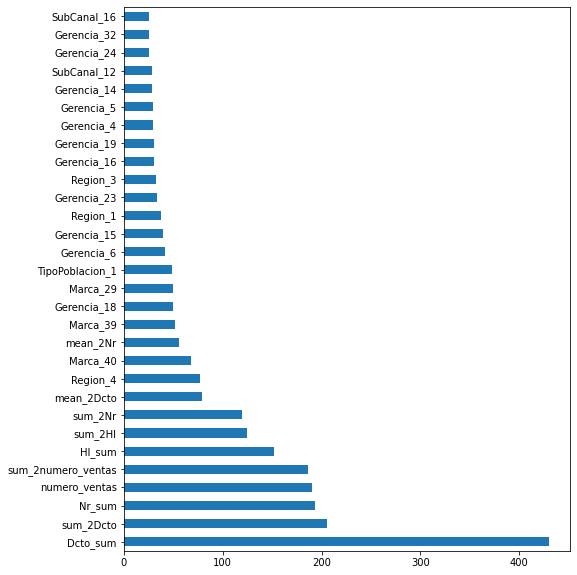

In [314]:
feat_imp = pd.Series(classifier_lgbm_todo.feature_importances_, index=X_train_todo.columns)
feat_imp.nlargest(30).plot(kind='barh', figsize=(8,10))

# LGBM v2 : base line training code

In [310]:
SEARCH_PARAMS = {'learning_rate': 0.4,
                 'max_depth': 15,
                 'num_leaves': 20,
                 'feature_fraction': 0.8,
                 'subsample': 0.2}
FIXED_PARAMS={'objective': 'binary',
              'metric': 'auc',
              'is_unbalance':True,
              'boosting':'gbdt',
              'num_boost_round':300,
              'early_stopping_rounds':30}

In [311]:
def train_evaluate(search_params):
  # you can download the dataset from this link(https://www.kaggle.com/c/santander-customer-transaction-prediction/data)
  # import Dataset to play with it
  data= df_m6_dummies
  X = data.drop(['label'], axis=1)
  y = data['label']
  
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=1234)
  
  train_data = lgb.Dataset(X_train, label=y_train)
  valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)

  params = {'metric':FIXED_PARAMS['metric'],
           'objective':FIXED_PARAMS['objective'],
           **search_params}

  model = lgb.train(params, train_data,                     
                   valid_sets=[valid_data],
                   num_boost_round=FIXED_PARAMS['num_boost_round'],
                   early_stopping_rounds=FIXED_PARAMS['early_stopping_rounds'],
                   valid_names=['valid'])
  score = model.best_score['valid']['auc']
  return score

train_evaluate(SEARCH_PARAMS)

[LightGBM] [Info] Number of positive: 22259, number of negative: 286382
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2715
[LightGBM] [Info] Number of data points in the train set: 308641, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.072119 -> initscore=-2.554580
[LightGBM] [Info] Start training from score -2.554580
[1]	valid's auc: 0.841448
Training until validation scores don't improve for 30 rounds
[2]	valid's auc: 0.861413
[3]	valid's auc: 0.864031
[4]	valid's auc: 0.867779
[5]	valid's auc: 0.870102
[6]	valid's auc: 0.87086
[7]	valid's auc: 0.871576
[8]	valid's auc: 0.872624
[9]	valid's auc: 0.873682
[10]	valid's auc: 0.874397
[11]	valid's auc: 0.875093
[12]	valid's auc: 0.87515
[13]	valid's auc: 0.876045
[14]	valid's auc: 0.876304
[15]	vali

0.8786008596537551

# Tunear LGBM

In [241]:

print(X_train_todo.shape)

print(X_test_todo.shape)


#model empty?
classifier_lgbm_tuned =  lgb.LGBMClassifier()
  
# define grid
param_grid = {
    'max_depth' :  [2, 8, 20 , 50], 
    'min_child_samples' :  [50, 100], 
#     'n_estimators' :  [10, 50, 100, 200], 
     'num_leaves' :  [15, 50, 100],
#     'objective' :  ['binary'], 
#     'reg_lambda' :  [10, 50, 100, 200], 
#     'scale_pos_weight':  [8, 10, 15],
#     'reg_alpha': [10, 50, 100], 
#     'colsample_bytree': [0.1, 0.2, 0.25]
}

# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=1)

# define grid search
grid = GridSearchCV(estimator = classifier_lgbm_tuned, 
                    param_grid = param_grid,
                    n_jobs = -1, 
                    cv = cv, 
                    scoring='roc_auc')

# execute the grid search
grid_result = grid.fit(X_train_todo, y_train_todo)

(289351, 96)
(96451, 96)


In [242]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.882416 using {'max_depth': 20, 'min_child_samples': 100, 'num_leaves': 50}


## Entrenamos con parametros optimos

In [282]:
classifier_lgbm_optim = lgb.LGBMClassifier(
  #n_estimators=100,
  #reg_lambda = 1,
  max_depth = 20,
  min_child_samples = 100,
  num_leaves = 50,
  objective='binary',
  scale_pos_weight = 12.882264042315859,
)

classifier_lgbm_optim.fit(X_train_todo, y_train_todo)
# make predictions for test data    
predictions = classifier_lgbm_optim.predict_proba(X_test_todo)[:, 1]
# evaluate predictions
print('ROC AUC Score',roc_auc_score(y_test_todo, predictions))
# old ROC AUC Score 0.8972606476313741

ROC AUC Score 0.8807384367810331


# ARMAR EL TEST SET

In [345]:
df_test = pd.read_csv(fp_test, encoding='ISO-8859-1', sep=',')
df_test.head(1)

SyntaxError: invalid syntax (<ipython-input-345-20d27cdff70c>, line 2)

In [ ]:
# Agregar month_year = '201908', se asume
df_test['month_year'] = pd.Period('2019-08', 'M')
# Dropear Ejecuto_Promo, al final lo agrego otra vez
df_test = df_test.drop('Ejecuto_Promo', axis = 1)
print(df_test.isna().sum().sum())
display(df_test.head(1))

In [ ]:
# Agregamos informacion de clientes sin enriquecer
df_t1 = pd.merge(
  df_test,
  df_clients[['Cliente', 'Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF']],
  on = 'Cliente',
  how = 'left'
)
print(df_t1.isna().sum().sum())
display(df_t1.head(1))

In [346]:
# Agregamos informacion de ventas enriquecida
df_t2 = pd.merge(
  df_t1,
  df_ventas_enriched,
  on = ['month_year', 'Cliente'],
  how = 'left'  
)
print(df_t2.isna().sum().sum())
display(df_t2.head(1))

0


,Cliente,Marca,Cupo,month_year,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas
0,10,40,16,2019-08,4,21,15,2,2,0,818199.93,14,3.58,-43358.46,1521431.02,760715.51,6.66,3.33,-62775.26,-31387.63,14,29.0,14.5


In [347]:
# ESTO SE DEBERIA IMPORTAR DE UN UTILITARIO
def obtener_prop_num(df, col_variable):
  """
  df: pd.Dataframe
  col_variable: str
  """
  # Copia: para asegurarnos que no modificamos df -> se debe hacer refactoring
  c_df = copy.deepcopy(df)
  # Cuenta de registros en tabla de clientes
  numero_clientes = len(c_df)
  
  # Contamos registros por valor de col_variable
  df_g1 = c_df.groupby([col_variable]).agg({
    'FechaAltaCliente': 'count',
  }).reset_index()
  
  # Creamos nombre de la columna donde se almacena el numero de clientes
  col_num_clientes = 'num_clientes_' + col_variable
  # Renombrar columna donde se almacena el numero de clientes
  df_g1 = df_g1.rename(columns={'FechaAltaCliente': col_num_clientes})
  # Creamos nombre de la columna donde se almacena la proporcion de clientes
  col_proporcion_clientes = 'prop_clientes_' + col_variable
  # Agregamos columna que almacena informacion de propocion de clientes 
  df_g1[col_proporcion_clientes] = df_g1[col_num_clientes] / numero_clientes
  
  return df_g1


# Agregamos informacion de prop_num 
cols_cat_clientes = ['Region', 'Gerencia', 'SubCanal', 'TipoPoblacion', 'Estrato', 'EF']
df_t3 = copy.deepcopy(df_t2)
for col_name in cols_cat_clientes:
  curr_df = obtener_prop_num(df_clients, col_name) 
  df_t3 = pd.merge(df_t3, curr_df, how = 'left', on = col_name)
  #print(df_t3.isna().sum().sum())
print(df_t3.isna().sum().sum())
display(df_t3.head(1))  

0


,Cliente,Marca,Cupo,month_year,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,num_clientes_Region,prop_clientes_Region,num_clientes_Gerencia,prop_clientes_Gerencia,num_clientes_SubCanal,prop_clientes_SubCanal,num_clientes_TipoPoblacion,prop_clientes_TipoPoblacion,num_clientes_Estrato,prop_clientes_Estrato,num_clientes_EF,prop_clientes_EF
0,10,40,16,2019-08,4,21,15,2,2,0,818199.93,14,3.58,-43358.46,1521431.02,760715.51,6.66,3.33,-62775.26,-31387.63,14,29.0,14.5,3531,0.234322,434,0.028801,2293,0.152167,11718,0.777623,6598,0.437853,9664,0.641317


In [348]:
# Agregar info de promo ofrecidas
df_t4 = pd.merge(
  df_t3,
  df_promo_ofrecidas,
  on = ['month_year', 'Cliente', 'Marca', 'Cupo'],
  how = 'left'
)
print(df_t4.isna().sum().sum())
display(df_t4.head(1))  

1025


,Cliente,Marca,Cupo,month_year,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,num_clientes_Region,prop_clientes_Region,num_clientes_Gerencia,prop_clientes_Gerencia,num_clientes_SubCanal,prop_clientes_SubCanal,num_clientes_TipoPoblacion,prop_clientes_TipoPoblacion,num_clientes_Estrato,prop_clientes_Estrato,num_clientes_EF,prop_clientes_EF,Num_prom_ofr
0,10,40,16,2019-08,4,21,15,2,2,0,818199.93,14,3.58,-43358.46,1521431.02,760715.51,6.66,3.33,-62775.26,-31387.63,14,29.0,14.5,3531,0.234322,434,0.028801,2293,0.152167,11718,0.777623,6598,0.437853,9664,0.641317,2.0


In [349]:
# Llena con 0 los NaN en Num_prom_ofr porque significa que no se ofrecieron descuentos
df_t4['Num_prom_ofr'] = df_t4['Num_prom_ofr'].fillna(0)
print(df_t4.isna().sum().sum())
display(df_t4.head(1))  

0


,Cliente,Marca,Cupo,month_year,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,num_clientes_Region,prop_clientes_Region,num_clientes_Gerencia,prop_clientes_Gerencia,num_clientes_SubCanal,prop_clientes_SubCanal,num_clientes_TipoPoblacion,prop_clientes_TipoPoblacion,num_clientes_Estrato,prop_clientes_Estrato,num_clientes_EF,prop_clientes_EF,Num_prom_ofr
0,10,40,16,2019-08,4,21,15,2,2,0,818199.93,14,3.58,-43358.46,1521431.02,760715.51,6.66,3.33,-62775.26,-31387.63,14,29.0,14.5,3531,0.234322,434,0.028801,2293,0.152167,11718,0.777623,6598,0.437853,9664,0.641317,2.0


In [350]:
f_prop = '../tablones/data_grupo2_proporcion.pkl' 
df_prop_enriched = load_pickle(f_prop)
df_prop_enriched.head(1)

# Cruzamos df_prop_enriched(enriched) 
df_t5 = pd.merge(
  df_t4,
  df_prop_enriched,
  on = ['month_year', 'Cliente'],
  how = 'left'
)
print(df_t5.isna().sum()/len(df_t5)*100)
print(df_t5.isna().sum().sum())
display(df_t5.head(1))

Cliente                        0.0
Marca                          0.0
Cupo                           0.0
month_year                     0.0
Region                         0.0
Gerencia                       0.0
SubCanal                       0.0
TipoPoblacion                  0.0
Estrato                        0.0
EF                             0.0
Nr_sum                         0.0
numero_ventas                  0.0
Hl_sum                         0.0
Dcto_sum                       0.0
sum_2Nr                        0.0
mean_2Nr                       0.0
sum_2Hl                        0.0
mean_2Hl                       0.0
sum_2Dcto                      0.0
mean_2Dcto                     0.0
numero_ventas_sum              0.0
sum_2numero_ventas             0.0
mean_2numero_ventas            0.0
num_clientes_Region            0.0
prop_clientes_Region           0.0
num_clientes_Gerencia          0.0
prop_clientes_Gerencia         0.0
num_clientes_SubCanal          0.0
prop_clientes_SubCan

,Cliente,Marca,Cupo,month_year,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,num_clientes_Region,prop_clientes_Region,num_clientes_Gerencia,prop_clientes_Gerencia,num_clientes_SubCanal,prop_clientes_SubCanal,num_clientes_TipoPoblacion,prop_clientes_TipoPoblacion,num_clientes_Estrato,prop_clientes_Estrato,num_clientes_EF,prop_clientes_EF,Num_prom_ofr,ofertas_dadas
0,10,40,16,2019-08,4,21,15,2,2,0,818199.93,14,3.58,-43358.46,1521431.02,760715.51,6.66,3.33,-62775.26,-31387.63,14,29.0,14.5,3531,0.234322,434,0.028801,2293,0.152167,11718,0.777623,6598,0.437853,9664,0.641317,2.0,5


In [351]:
df_t5.shape

(16870, 37)

In [352]:
# Agregar categoricas a df_t5

In [353]:
# Crear dummies
COLS_ONEHOT = [
  'Region',
  'Gerencia',
  'SubCanal',
  'TipoPoblacion',
  'Marca',
  'Cupo',
  'Estrato',
  'EF'
]

df_t5_dummies = copy.deepcopy(df_t5)
for col_name in COLS_ONEHOT:
  df_t5_dummies[col_name] = df_t5_dummies[col_name].astype(str)
df_t5_dummies.head(1)

,Cliente,Marca,Cupo,month_year,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,num_clientes_Region,prop_clientes_Region,num_clientes_Gerencia,prop_clientes_Gerencia,num_clientes_SubCanal,prop_clientes_SubCanal,num_clientes_TipoPoblacion,prop_clientes_TipoPoblacion,num_clientes_Estrato,prop_clientes_Estrato,num_clientes_EF,prop_clientes_EF,Num_prom_ofr,ofertas_dadas
0,10,40,16,2019-08,4,21,15,2,2,0,818199.93,14,3.58,-43358.46,1521431.02,760715.51,6.66,3.33,-62775.26,-31387.63,14,29.0,14.5,3531,0.234322,434,0.028801,2293,0.152167,11718,0.777623,6598,0.437853,9664,0.641317,2.0,5


In [354]:
dummies_tdf_temp = pd.get_dummies(df_t5_dummies[COLS_ONEHOT], prefix = COLS_ONEHOT)
dummies_tdf_temp.head(1)

,Region_1,Region_2,Region_3,Region_4,Region_5,Gerencia_10,Gerencia_11,Gerencia_12,Gerencia_13,Gerencia_14,Gerencia_15,Gerencia_16,Gerencia_17,Gerencia_18,Gerencia_19,Gerencia_2,Gerencia_20,Gerencia_21,Gerencia_22,Gerencia_23,Gerencia_24,Gerencia_25,Gerencia_26,Gerencia_27,Gerencia_28,Gerencia_29,Gerencia_3,Gerencia_30,Gerencia_31,Gerencia_32,Gerencia_33,Gerencia_36,Gerencia_4,Gerencia_5,Gerencia_6,Gerencia_7,Gerencia_8,Gerencia_9,SubCanal_1,SubCanal_10,SubCanal_11,SubCanal_12,SubCanal_13,SubCanal_14,SubCanal_15,SubCanal_16,SubCanal_17,SubCanal_18,SubCanal_19,SubCanal_2,SubCanal_20,SubCanal_22,SubCanal_23,SubCanal_24,SubCanal_25,SubCanal_27,SubCanal_3,SubCanal_4,SubCanal_6,SubCanal_7,SubCanal_8,SubCanal_9,TipoPoblacion_1,TipoPoblacion_2,Marca_29,Marca_39,Marca_40,Cupo_16,Cupo_20,Cupo_9,Estrato_1,Estrato_2,Estrato_3,Estrato_4,Estrato_5,Estrato_6,EF_0,EF_1
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0


In [355]:
# df_t4_dummies = pd.get_dummies(df_t4_dummies, prefix = COLS_ONEHOT)
# concnat horizontally
df_t6_dummies = pd.concat([df_t5_dummies, dummies_tdf_temp], axis=1)

print(df_t6_dummies.isna().sum().sum())
display(df_t6_dummies.head(1))

0


,Cliente,Marca,Cupo,month_year,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,num_clientes_Region,prop_clientes_Region,num_clientes_Gerencia,prop_clientes_Gerencia,num_clientes_SubCanal,prop_clientes_SubCanal,num_clientes_TipoPoblacion,prop_clientes_TipoPoblacion,num_clientes_Estrato,prop_clientes_Estrato,num_clientes_EF,prop_clientes_EF,Num_prom_ofr,ofertas_dadas,Region_1,Region_2,Region_3,Region_4,Region_5,Gerencia_10,Gerencia_11,Gerencia_12,Gerencia_13,Gerencia_14,Gerencia_15,Gerencia_16,Gerencia_17,Gerencia_18,Gerencia_19,Gerencia_2,Gerencia_20,Gerencia_21,Gerencia_22,Gerencia_23,Gerencia_24,Gerencia_25,Gerencia_26,Gerencia_27,Gerencia_28,Gerencia_29,Gerencia_3,Gerencia_30,Gerencia_31,Gerencia_32,Gerencia_33,Gerencia_36,Gerencia_4,Gerencia_5,Gerencia_6,Gerencia_7,Gerencia_8,Gerencia_9,SubCanal_1,SubCanal_10,SubCanal_11,SubCanal_12,SubCanal_13,SubCanal_14,SubCanal_15,SubCanal_16,SubCanal_17,SubCanal_18,SubCanal_19,SubCanal_2,SubCanal_20,SubCanal_22,SubCanal_23,SubCanal_24,SubCanal_25,SubCanal_27,SubCanal_3,SubCanal_4,SubCanal_6,SubCanal_7,SubCanal_8,SubCanal_9,TipoPoblacion_1,TipoPoblacion_2,Marca_29,Marca_39,Marca_40,Cupo_16,Cupo_20,Cupo_9,Estrato_1,Estrato_2,Estrato_3,Estrato_4,Estrato_5,Estrato_6,EF_0,EF_1
0,10,40,16,2019-08,4,21,15,2,2,0,818199.93,14,3.58,-43358.46,1521431.02,760715.51,6.66,3.33,-62775.26,-31387.63,14,29.0,14.5,3531,0.234322,434,0.028801,2293,0.152167,11718,0.777623,6598,0.437853,9664,0.641317,2.0,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0


In [356]:
# Dropear columnas que se volvieron dummies
df_t6_dummies = df_t6_dummies.drop(COLS_ONEHOT, axis=1)
print(df_t6_dummies.isna().sum().sum())
display(df_t6_dummies.head(1))

0


,Cliente,month_year,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,num_clientes_Region,prop_clientes_Region,num_clientes_Gerencia,prop_clientes_Gerencia,num_clientes_SubCanal,prop_clientes_SubCanal,num_clientes_TipoPoblacion,prop_clientes_TipoPoblacion,num_clientes_Estrato,prop_clientes_Estrato,num_clientes_EF,prop_clientes_EF,Num_prom_ofr,ofertas_dadas,Region_1,Region_2,Region_3,Region_4,Region_5,Gerencia_10,Gerencia_11,Gerencia_12,Gerencia_13,Gerencia_14,Gerencia_15,Gerencia_16,Gerencia_17,Gerencia_18,Gerencia_19,Gerencia_2,Gerencia_20,Gerencia_21,Gerencia_22,Gerencia_23,Gerencia_24,Gerencia_25,Gerencia_26,Gerencia_27,Gerencia_28,Gerencia_29,Gerencia_3,Gerencia_30,Gerencia_31,Gerencia_32,Gerencia_33,Gerencia_36,Gerencia_4,Gerencia_5,Gerencia_6,Gerencia_7,Gerencia_8,Gerencia_9,SubCanal_1,SubCanal_10,SubCanal_11,SubCanal_12,SubCanal_13,SubCanal_14,SubCanal_15,SubCanal_16,SubCanal_17,SubCanal_18,SubCanal_19,SubCanal_2,SubCanal_20,SubCanal_22,SubCanal_23,SubCanal_24,SubCanal_25,SubCanal_27,SubCanal_3,SubCanal_4,SubCanal_6,SubCanal_7,SubCanal_8,SubCanal_9,TipoPoblacion_1,TipoPoblacion_2,Marca_29,Marca_39,Marca_40,Cupo_16,Cupo_20,Cupo_9,Estrato_1,Estrato_2,Estrato_3,Estrato_4,Estrato_5,Estrato_6,EF_0,EF_1
0,10,2019-08,818199.93,14,3.58,-43358.46,1521431.02,760715.51,6.66,3.33,-62775.26,-31387.63,14,29.0,14.5,3531,0.234322,434,0.028801,2293,0.152167,11718,0.777623,6598,0.437853,9664,0.641317,2.0,5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0


In [357]:
#X_train_todo.head(1)

In [358]:
df_t5.head(1)

,Cliente,Marca,Cupo,month_year,Region,Gerencia,SubCanal,TipoPoblacion,Estrato,EF,Nr_sum,numero_ventas,Hl_sum,Dcto_sum,sum_2Nr,mean_2Nr,sum_2Hl,mean_2Hl,sum_2Dcto,mean_2Dcto,numero_ventas_sum,sum_2numero_ventas,mean_2numero_ventas,num_clientes_Region,prop_clientes_Region,num_clientes_Gerencia,prop_clientes_Gerencia,num_clientes_SubCanal,prop_clientes_SubCanal,num_clientes_TipoPoblacion,prop_clientes_TipoPoblacion,num_clientes_Estrato,prop_clientes_Estrato,num_clientes_EF,prop_clientes_EF,Num_prom_ofr,ofertas_dadas
0,10,40,16,2019-08,4,21,15,2,2,0,818199.93,14,3.58,-43358.46,1521431.02,760715.51,6.66,3.33,-62775.26,-31387.63,14,29.0,14.5,3531,0.234322,434,0.028801,2293,0.152167,11718,0.777623,6598,0.437853,9664,0.641317,2.0,5


# Hacemos que df_t5 tenga las mismas columnas que el X_train_todo

In [359]:
# Agregar columnas manualmente
df_t6_dummies['SubCanal_26'] = 0
df_t6_dummies['Gerencia_34'] = 0
df_t6_dummies['Gerencia_37'] = 0
df_t6_dummies['Gerencia_35'] = 0
df_t6_dummies['SubCanal_5'] = 0

In [362]:
df_m6_dummies.columns

Index(['label', 'Nr_sum', 'numero_ventas', 'Hl_sum', 'Dcto_sum', 'sum_2Nr',
       'mean_2Nr', 'sum_2Hl', 'mean_2Hl', 'sum_2Dcto', 'mean_2Dcto',
       'numero_ventas_sum', 'sum_2numero_ventas', 'mean_2numero_ventas',
       'Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5',
       'Gerencia_10', 'Gerencia_11', 'Gerencia_12', 'Gerencia_13',
       'Gerencia_14', 'Gerencia_15', 'Gerencia_16', 'Gerencia_17',
       'Gerencia_18', 'Gerencia_19', 'Gerencia_2', 'Gerencia_20',
       'Gerencia_21', 'Gerencia_22', 'Gerencia_23', 'Gerencia_24',
       'Gerencia_25', 'Gerencia_26', 'Gerencia_27', 'Gerencia_28',
       'Gerencia_29', 'Gerencia_3', 'Gerencia_30', 'Gerencia_31',
       'Gerencia_32', 'Gerencia_33', 'Gerencia_34', 'Gerencia_35',
       'Gerencia_36', 'Gerencia_37', 'Gerencia_4', 'Gerencia_5', 'Gerencia_6',
       'Gerencia_7', 'Gerencia_8', 'Gerencia_9', 'SubCanal_1', 'SubCanal_10',
       'SubCanal_11', 'SubCanal_12', 'SubCanal_13', 'SubCanal_14',
       'SubCanal_15', 'S

In [364]:
df_t6_dummies = df_t6_dummies[list(df_m6_dummies.columns)]

In [365]:
df_t6_dummies.isna().sum().sum()

0

## Prediccion

In [367]:
#pred = classifier_lgbm_dummies.predict_proba(df_t4_dummies)
#pred = classifier_prod.predict_proba(df_t5_dummies)
#pred = classifier_lgbm_optim.predict_proba(df_t6_dummies)
pred = clf.predict(df_t6_dummies)


In [368]:
print(pred)

[0.09648307 0.09003819 0.06407276 ... 0.1078832  0.08196492 0.10052095]


In [369]:
lista_pred_compro = [x for _, x in pred]
len(lista_pred_compro)

TypeError: cannot unpack non-iterable numpy.float64 object

In [ ]:
df_output = pd.read_csv(fp_test, encoding='ISO-8859-1', sep=',')
df_output.tail(1)

In [370]:
df_output['Ejecuto_Promo'] = lista_pred_compro
print(df_output.isna().sum().sum())
display(df_output.head(1))

0


,Cliente,Marca,Cupo,Ejecuto_Promo
0,10,40,16,0.096483


In [371]:
import time
fp = '../output/' +  str(time.asctime()) + '.csv'
fp = '../output/' + 'asddd.csv'
fp

'../output/asddd.csv'

In [372]:
# Almacenar 
df_output = df_output.reset_index(drop=True)
display(df_output.head(1))


,Cliente,Marca,Cupo,Ejecuto_Promo
0,10,40,16,0.096483


In [373]:
df_output.to_csv(fp, sep = ',', columns = ['Cliente', 'Marca', 'Cupo', 'Ejecuto_Promo'], index=False)